In [1]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score
import pandas as pd
import string
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import collections
import pickle

## Data

In [2]:
df=pd.read_excel('data/sentiment_data/training_data.xlsx')

In [3]:
df.head()

,y,text
0,positive,The Da Vinci Code book is just awesome.
1,positive,this was the first clive cussler i've ever rea...
2,positive,i liked the Da Vinci Code a lot.
3,positive,i liked the Da Vinci Code a lot.
4,positive,I liked the Da Vinci Code but it ultimatly did...


## Classes

In [13]:
class Network(object):
    '''generic class for network building. Exact implementation is in subclasses'''
    
    def __init__(self,x, y, nn_structure, test_size):
        """initiate NN with x and y texts, also clean data and turn it into matrix
        """
        
        self.X=x #matrix
        self.y=y #matrix
        self.nn_structure=nn_structure #list of nr of in each layer
    
        #split test and trainig data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=test_size)
        #vectorize y
        self.y_v_train=self.convert_y_to_vect(self.y_train)
        self.y_v_test=self.convert_y_to_vect(self.y_test)
        self.y_pred=None
        
        self.avg_cost_func=[]
        self.W=None
        self.b=None
        
                 
    def convert_y_to_vect(self, y):
        y_vect = np.zeros((len(y), len(self.y_dictionary)))
        for i in range(len(y)):
            y_vect[i, y[i]] = 1
        return y_vect

    
    def f(self, x):
        return 1 / (1 + np.exp(-x))
        
        
    def f_deriv(self,x):
        return self.f(x) * (1 - self.f(x))
    
    
    def setup_and_init_weights(self):
        W = {}
        b = {}
        for l in range(1, len(self.nn_structure)):
            W[l] = np.random.random_sample((self.nn_structure[l], self.nn_structure[l-1]))
            b[l] = np.random.random_sample((self.nn_structure[l],))
        return W, b
    
    
    def init_tri_values(self):
        tri_W = {}
        tri_b = {}
        for l in range(1, len(self.nn_structure)):
            tri_W[l] = np.zeros((self.nn_structure[l], self.nn_structure[l-1]))
            tri_b[l] = np.zeros((self.nn_structure[l],))
        return tri_W, tri_b
    
    
    def feed_forward(self, x, W, b):
        h = {1: x}
        z = {}
        for l in range(1, len(W) + 1):
            # if it is the first layer, then the input into the weights is x, otherwise, 
            # it is the output from the last layer
            if l == 1:
                node_in = x
            else:
                node_in = h[l]
            z[l+1] = W[l].dot(node_in) + b[l] # z^(l+1) = W^(l)*h^(l) + b^(l)  
            h[l+1] = self.f(z[l+1]) # h^(l) = f(z^(l)) 
        return h, z
    
    
    def calculate_out_layer_delta(self, y, h_out, z_out):
        # delta^(nl) = -(y_i - h_i^(nl)) * f'(z_i^(nl))
        return -(y-h_out) * self.f_deriv(z_out)
    
    
    def calculate_hidden_delta(self, delta_plus_1, w_l, z_l):
        # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(z^(l))
        return np.dot(np.transpose(w_l), delta_plus_1) * self.f_deriv(z_l)
    
    
    def train_nn(self):
        '''implemented in subclass'''
        raise NotImplementedError

        
    def plot_avg_cost_func(self):
        if len(self.avg_cost_func)==0:
            print('Please train model before visalizing average cost')
            return
        plt.plot(self.avg_cost_func)
        plt.ylabel('Average J')
        plt.xlabel('Iteration number')
        plt.show()
        
        
    def predict_test_data(self):
        m = self.X_test.shape[0]
        y = np.zeros((m,))
        for i in range(m):
            h, z = self.feed_forward(self.X_test[i, :], self.W, self.b)
            y[i] = np.argmax(h[len(self.nn_structure)])
        self.y_pred=y
        
        
    def get_test_accuracy(self):
        self.predict_test_data()
        return accuracy_score(self.y_test, self.y_pred)*100
    
    
    def pickle(self, filename):
        '''save model to file'''
        f = open(filename, 'wb')
        pickle.dump(self, f, pickle.HIGHEST_PROTOCOL)
        f.close()
        
        
    @staticmethod
    def unpickle(filename):
        '''read model from file'''
        with open(filename, 'rb') as f:
            return pickle.load(f)

In [27]:
class NetworkMBGD(Network):
    '''class for minibatch gradient descent'''
    
    def __init__(self,x, y, nn_structure, test_size):
        Network.__init__(self,  x, y, nn_structure, test_size)
        self.lamb=None
        self.alpha=None
        self.iter_num=None
        
        
    def get_mini_batches(self, X, y, batch_size):
        random_idxs = np.random.choice(len(y), len(y), replace=False)
        X_shuffled = self.X_train[random_idxs,:]
        y_shuffled = self.y_v_train[random_idxs]
        mini_batches = [(X_shuffled[i:i+batch_size,:], y_shuffled[i:i+batch_size]) for
                       i in range(0, len(self.y_v_train), batch_size)]
        return mini_batches
    
    
    def train_nn(self, iter_num=3000, bs=100, alpha=0.25, lamb=0.000):
        self.lamb=lamb
        self.alpha=alpha
        self.iter_num=iter_num
        #reset avg cost
        if len(self.avg_cost_func)>0:
            self.avg_cost_func=[]
        
        W, b = self.setup_and_init_weights()
        cnt = 0
        m = len(self.y_v_train)
        print('Starting gradient descent for {} iterations'.format(iter_num))
        while cnt < iter_num:
            if cnt%1000 == 0:
                print('Iteration {} of {}'.format(cnt, iter_num))
            tri_W, tri_b = self.init_tri_values()
            avg_cost = 0
            mini_batches = self.get_mini_batches(self.X_train, self.y_v_train, bs)
            for mb in mini_batches:
                X_mb = mb[0]
                y_mb = mb[1]
                # pdb.set_trace()
                for i in range(len(y_mb)):
                    delta = {}
                    # perform the feed forward pass and return the stored h and z values, 
                    # to be used in the gradient descent step
                    h, z = self.feed_forward(X_mb[i, :], W, b)
                    # loop from nl-1 to 1 backpropagating the errors
                    for l in range(len(self.nn_structure), 0, -1):
                        if l == len(self.nn_structure):
                            delta[l] = self.calculate_out_layer_delta(y_mb[i,:], h[l], z[l])
                            avg_cost += np.linalg.norm((y_mb[i,:]-h[l]))
                        else:
                            if l > 1:
                                delta[l] = self.calculate_hidden_delta(delta[l+1], W[l], z[l])
                            # triW^(l) = triW^(l) + delta^(l+1) * transpose(h^(l))
                            tri_W[l] += np.dot(delta[l+1][:,np.newaxis], 
                                              np.transpose(h[l][:,np.newaxis])) 
                            # trib^(l) = trib^(l) + delta^(l+1)
                            tri_b[l] += delta[l+1]
                # perform the gradient descent step for the weights in each layer
                for l in range(len(self.nn_structure) - 1, 0, -1):
                    W[l] += -alpha * (1.0/bs * tri_W[l] + lamb * W[l])
                    b[l] += -alpha * (1.0/bs * tri_b[l])
            # complete the average cost calculation
            avg_cost = 1.0/m * avg_cost
            self.avg_cost_func.append(avg_cost)
            cnt += 1
        self.W=W
        self.b=b

In [36]:
class TextMBGD(NetworkMBGD):
    '''wrapper class for NetworkMBGD to make textual data edible for it'''
    
    def __init__(self,x_texts, y_texts, nn_structure, test_size, n_words=10000, custom_chars_to_remove=None):
            
        self.x_texts=x_texts
        self.y_texts=y_texts  
        
        #cleaning stuff
        self.n_words=n_words
        self.custom_chars_to_remove=custom_chars_to_remove
        self.cleaner=TextCleaner(self.custom_chars_to_remove)
        self.scaler = StandardScaler()
        
        #init X dataset
        self.X_count=None
        self.X_dictionary=None
        self.X_reversed_dictionary=None
        self.build_x_dataset()
        
        #init y dataset
        self.y_dictionary=None
        self.y_reversed_dictionary=None
        self.build_y_dataset()
        
        NetworkMBGD.__init__(self, self.build_x_dataset(), self.build_y_dataset(), nn_structure, test_size)
        
        
    def build_x_dataset(self):
        '''build dataset for neural network. turns texts into matrix
        INPUT: 
            - n_words: nr of top sequence words kept, others words are makerd as unknown
            - texts_list_raw: list of texts to be build a dataset. each list element is 1 row
        '''
        
        texts_list=[]
        texts_tokenized=[]
        words=[]
        max_sentence_len=0

        for sentence in self.x_texts:
            text_words=self.cleaner.preporcess_text(sentence)
            texts_tokenized.append(text_words)
            words.extend(text_words)
            if len(text_words)>max_sentence_len:
                max_sentence_len=len(text_words)

        #set normalised sentence len, other ideas?
        normalized_sentence_len=max_sentence_len
        #unknonown words count
        count = [['UNK', -1]]

        count.extend(collections.Counter(words).most_common(self.n_words - 1))
        dictionary = dict()
        for word, _ in count:
            dictionary[word] = len(dictionary)
        data = list()
        unk_count = 0
        for text in texts_tokenized:
            text_data=[]
            for word in text:
                if word in dictionary:
                    index = dictionary[word]
                else:
                    index = 0  # dictionary['UNK']
                    unk_count += 1
                text_data.append(index)
            if len(text_data)<normalized_sentence_len:
                text_data.extend([0] * (normalized_sentence_len-len(text_data)))

            data.append(text_data)

        count[0][1] = unk_count
        reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
        
        self.X_count=count
        self.X_dictionary=dictionary
        self.X_reversed_dictionary=reversed_dictionary
        return np.array(self.scaler.fit_transform(data))
        
        
    def build_y_dataset(self):
        '''build y dataset, dataset_y will be one hot vector. turns text into matrix'''
        dictionary={}
        cnt=0
        for word in set(self.y_texts):
            dictionary[word]=cnt
            cnt+=1

        dataset=[]
        for category in self.y_texts:
            dataset.append([dictionary[category]])
        reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
        
        self.y_dictionary=dictionary
        self.y_reversed_dictionary=reversed_dictionary
        return np.array(dataset)
        
        
    def text_to_vector(self, text):
        '''turns text to vector based on input data dictionary, for random text vectorization'''
        #make sep function for tokenization
        texts_tokenized=[]
        text_vector=[]
        text_words=self.cleaner.preporcess_text(text)
        texts_tokenized.extend(text_words)

        for token in texts_tokenized:
            if token in self.X_dictionary:
                text_vector.extend([self.X_dictionary[token]])
            else:
                text_vector.extend([0])

        return text_vector
    
    
    def predict_text_label(self, text):
        '''predicts label of text based on model'''
        text_vector=self.text_to_vector(text)
        #normalize lenght
        if len(text_vector)<self.X_test.shape[1]:
            text_vector.extend([0] * (self.X_test.shape[1]-len(text_vector)))

        h, z = self.feed_forward(text_vector, self.W, self.b)
        y = np.argmax(h[len(self.nn_structure)])
        y_label=self.y_reversed_dictionary[y]
        return y_label
    

## Example usage

In [37]:
nn_MBGD=TextMBGD(df['text'].tolist(), df['y'].tolist(),[40, 30, 2], 0.4)

In [38]:
% time nn_MBGD.train_nn(iter_num=120)

Starting gradient descent for 120 iterations
Iteration 0 of 120
CPU times: user 41.3 s, sys: 28 ms, total: 41.4 s
Wall time: 43.4 s


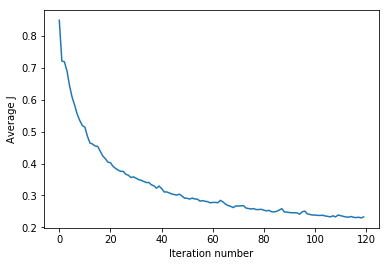

In [39]:
nn_MBGD.plot_avg_cost_func()

In [40]:
nn_MBGD.get_test_accuracy()

82.46913580246914